# Lecture 15 - Advanced Curve Fitting: Multivariate Gaussian Process Regression and Automatic Relevance Determination

In [31]:
import numpy as np
import scipy.stats as st

import GPy
import pyDOE

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

## Objectives

+ To demonstrate GP regression with multiple inputs.
+ To highlight how GP regression does automatic relevance determination.
+ To discuss the curse of dimensionality in the context of GP regression and some ways of dealing with it (active subspaces and high-dimensional model representation).

## Readings

+ [Rasmussen Gaussian process textbook](http://www.gaussianprocess.org/gpml/chapters/).

## Multivariate Gaussian Process Regression

When we say "multivariate" here we refer to many function inputs, not outputs.
This just means that the input of the function we are interested in learning is a vector $\mathbf{x}$ in $\mathbb{R}^D$.
In that regard, nothing really changes compared to one-input GPR.
The formulas are exactly the same.
However, in higher dimensional settings one must pay attention to the selection of the covariance function.

Let's demonstrate this using an example.
Here is an analytical function, known as the Branin-Hoo function:
$$
f(\mathbf{x}) = f(x_1,x_2) = \frac{1}{51.95}\left[\left(15x_2 - \frac{5.1(15x_1)^2}{4\pi^2} + \frac{75x_1}{\pi} - 6\right)^2 + \left(10 - \frac{10}{8\pi}\right)\cos(15x_1)-44.81\right]
$$
We will use this function to generate some synthetic data.
Let's superimpose the synthetic data on a contour of this function.

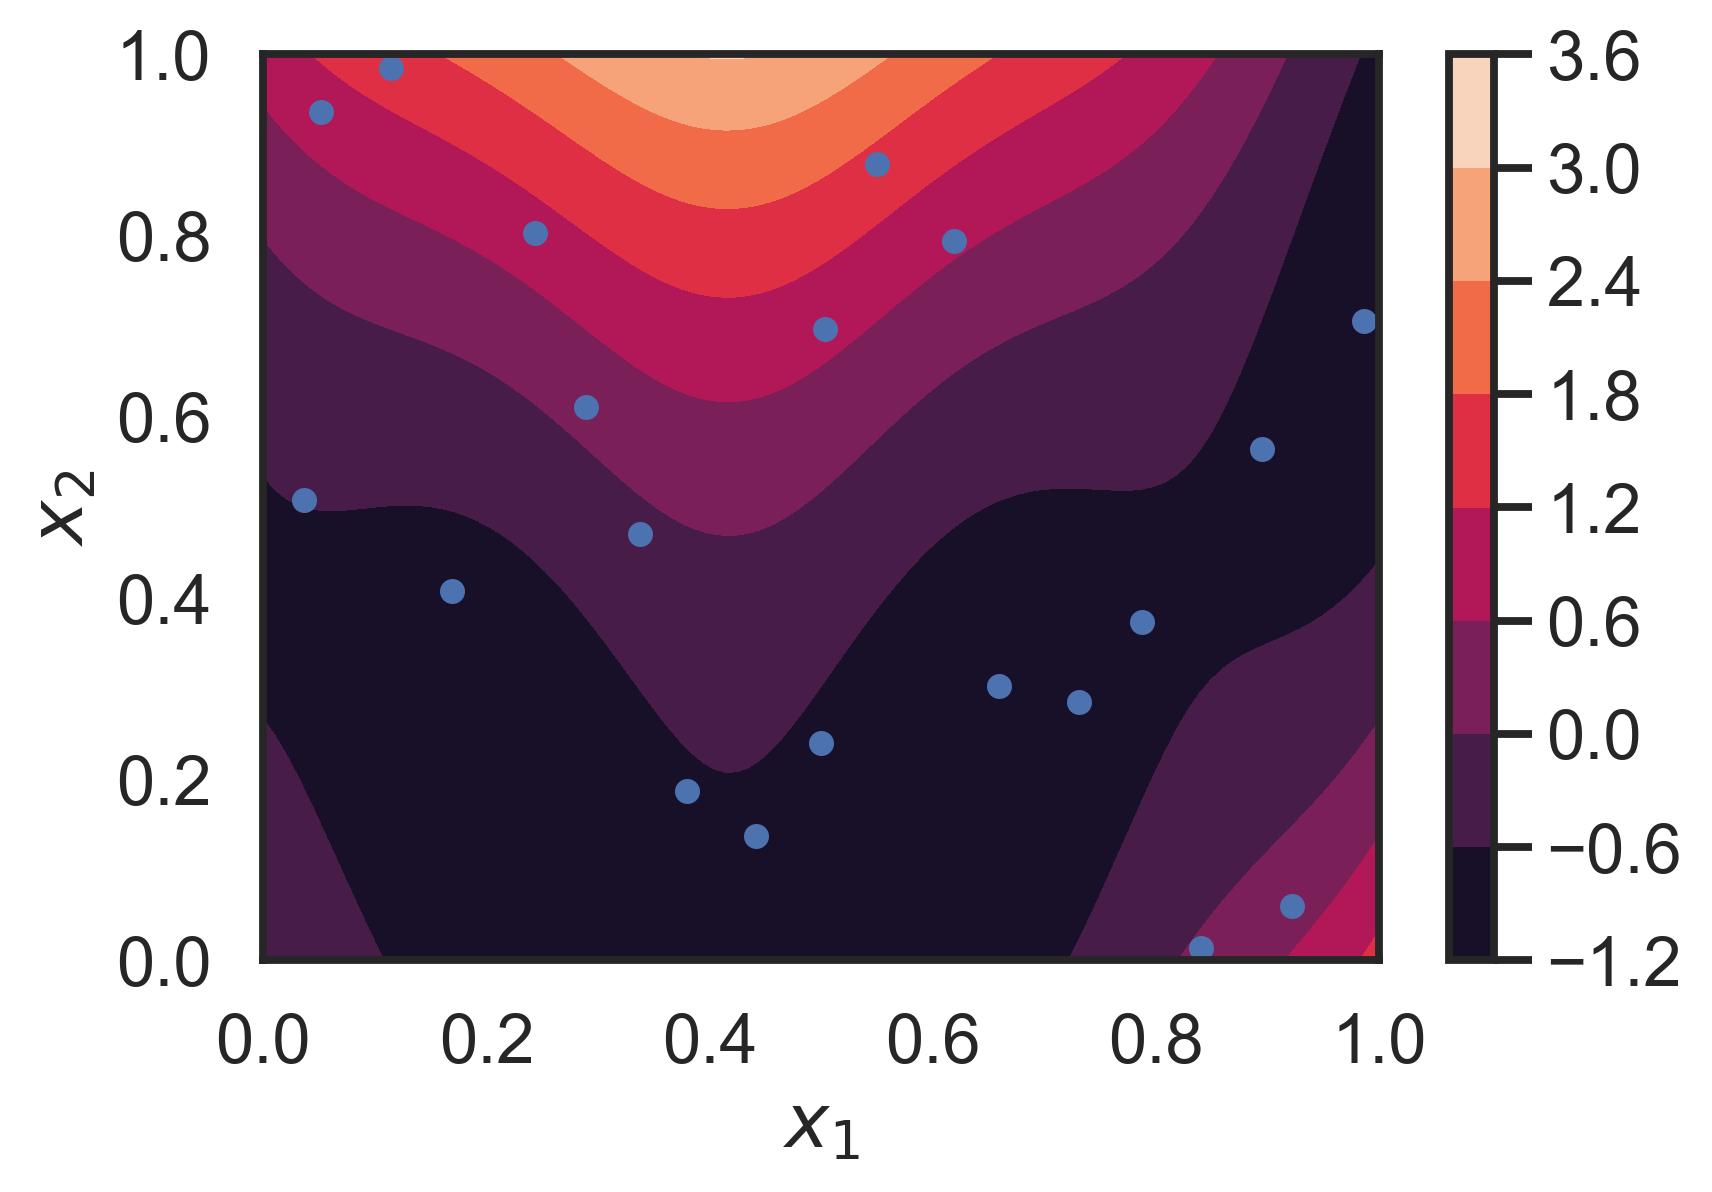

In [2]:
# Define the function
def f_branin(x):
    """
    Input must be 2D array of size N x 2.
    """
    return 1.0 / 51.95 * ((15.0 * x[:, 1] - 5.1 * (15.0 * x[:, 0]) ** 2 / 4.0 / np.pi ** 2 + 
                          75.0 * x[:, 0] / np.pi - 6.0) ** 2
                         + (10.0 - 10.0 / 8.0 / np.pi) * np.cos(15.0 * x[:, 0]) - 44.81)

# Generate synthetic data
n = 20
# Always use Latin-hypercube sampling when you get to pick the data
import pyDOE
X = pyDOE.lhs(2, n)
# We will also be adding a little bit of noise to the observations
sigma = 0.01
y = f_branin(X)[:, None] + sigma * np.random.randn(n, 1)

# Plot the contour and the observations
fig, ax = plt.subplots(dpi=300)
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_star_flat = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
Z_true = f_branin(X_star_flat).reshape(X1.shape)
c = ax.contourf(X1, X2, Z_true)
ax.plot(X[:, 0], X[:, 1], 'bo', markersize=5)
plt.colorbar(c)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

We will be using a the squared exponential covariance function for a regression along with a zero mean.
So our prior GP is:
$$
f(\cdot)\sim\operatorname{GP}(0, k(\cdot,\cdot)),
$$
with
$$
k(\mathbf{x}, \mathbf{x}') = s^2\exp\left(-\frac{(x_1-x_1')^2}{2\ell_1}-\frac{(x_2-x_2')^2}{2\ell_2}\right).
$$
The first, situation we are going to examin is when the lengthscales are the same:
$$
\ell_1 = \ell_2.
$$
This is what you get by default from ``GPy``:

In [32]:
k = GPy.kern.RBF(2) # The 2 here is for the dimensionality of the input space
gp = GPy.models.GPRegression(X, y, k)
print(gp)


Name : GP regression
Objective : 25.62718898351518
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


In [36]:
# perform the optimization 
gp.optimize_restarts(robust=True);

Optimization restart 1/10, f = 8.286339784157406
Optimization restart 2/10, f = 8.286339784354869
Optimization restart 3/10, f = 8.286339784157427
Optimization restart 4/10, f = 8.28633978416817
Optimization restart 5/10, f = 8.286339790914315
Optimization restart 6/10, f = 8.286339784190595
Optimization restart 7/10, f = 8.286339784157448
Optimization restart 8/10, f = 8.286339784180292
Optimization restart 9/10, f = 8.286339784158368
Optimization restart 10/10, f = 8.286339784665493


In [35]:
# print out the model details 
print(gp)


Name : GP regression
Objective : 8.286339784157406
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |     1.0477268324947488  |      +ve      |        
  rbf.lengthscale          |      0.282434461602814  |      +ve      |        
  Gaussian_noise.variance  |  0.0007902945666345676  |      +ve      |        


In [37]:
# check the lengthscale 
print(gp.kern.lengthscale)

  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                     0.28243446  |      +ve      |        


Text(0, 0.5, '$x_2$')

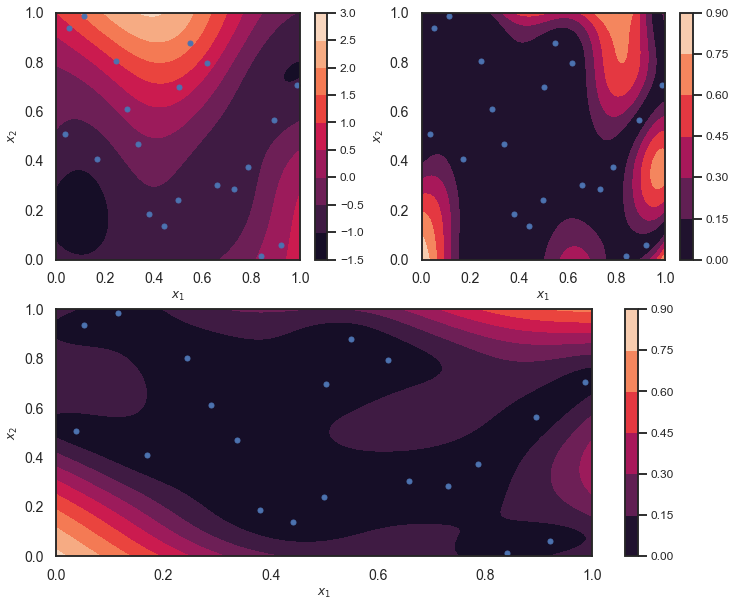

In [38]:
# Make predictions
z_flat, v_flat = gp.predict(X_star_flat)

# start a new figure
fig = plt.figure(figsize=(12, 10))

#plot the contour of the predictions (Compare to contour of true values above)
ax = plt.subplot(221)
ax.tick_params(axis='both', labelsize=14)
Z_star = z_flat[:, 0].reshape(X1.shape)
ax.plot(X[:, 0], X[:, 1], 'bo', markersize=5)
im = ax.contourf(X1, X2, Z_star)
cbar = plt.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=12)
ax.set_xlabel('$x_1$', fontsize=12)
ax.set_ylabel('$x_2$', fontsize=12)

# Let's also plot the contour of the error
ax = plt.subplot(222)
ax.tick_params(axis='both', labelsize=14)
E = np.abs(Z_true - Z_star)
ax.plot(X[:, 0], X[:, 1], 'bo', markersize=5)
im = ax.contourf(X1, X2, E)
cbar = plt.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=12)
ax.set_xlabel('$x_1$', fontsize=12)
ax.set_ylabel('$x_2$', fontsize=12)

# And let's compare the error plot to 2 x the predictive standard deviation
ax = plt.subplot(212)
ax.tick_params(axis='both', labelsize=14)
ax.plot(X[:, 0], X[:, 1], 'bo', markersize=5)
c = ax.contourf(X1, X2, 2.0 * np.sqrt(v_flat.reshape(X1.shape)))
cbar = plt.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=12)
ax.set_xlabel('$x_1$', fontsize=12)
ax.set_ylabel('$x_2$', fontsize=12)

Now let's repeat the same analysis but allowing for a different lengthscale per input.
First, we set up and train the model:

In [39]:
k = GPy.kern.RBF(2, ARD=True) # The ARD = True is what makes GPy understand that there is
                              # one lengthscale per dimension
gp = GPy.models.GPRegression(X, y, k)
print(gp)


Name : GP regression
Objective : 25.62718898351518
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |   (2,)  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


Note that you now cannot see what the lengthscale values are.
You need to do this to see them:

In [40]:
print(gp.rbf.lengthscale)

  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                     1.00000000  |      +ve      |        
  [1]    |                     1.00000000  |      +ve      |        


And you can train the model as usual:

In [41]:
gp.optimize_restarts(); # No messages shown here
print(gp)
print(gp.rbf.lengthscale)

Optimization restart 1/10, f = 2.4067831319248967
Optimization restart 2/10, f = 2.4067764173905815
Optimization restart 3/10, f = 2.4067519012561505
Optimization restart 4/10, f = 2.4067518943627455
Optimization restart 5/10, f = 2.406751898821444
Optimization restart 6/10, f = 2.4067519034659526
Optimization restart 7/10, f = 2.4067519073606363
Optimization restart 8/10, f = 2.406751894165666
Optimization restart 9/10, f = 2.4067518920522275
Optimization restart 10/10, f = 2.4067518918128847

Name : GP regression
Objective : 2.4067518918128847
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |     3.5579265269861766  |      +ve      |        
  rbf.lengthscale          |                   (2,)  |      +ve      |        
  Gaussian_noise.variance  |  5.278799417482966e-13  |      +ve      |        
  index  |  GP_regression.rbf.lengthscale 

So, you se that the lengthscale assigned to $x_1$ is slightly bigger than the lengthscale assigned to $x_2$. This means that the first input is slightly more important than the second input.
This is the automatic relevance determination (ARD) in action.

**ROHIT:**
+ Expand Branin function with a third variable with mild linear dependence, say $+10x_3$. Demonstrate the ARD picks this up.
+ Expand Branin function with a fourth variable that is not used at all.
+ Add questions on ARD.
+ Explain active subspaces (without any of the theory - just the structure of the function).
+ Use a covariance function like this:
$k(\mathbf{x},\mathbf{x}') = s^2 \exp\left\{-\frac{1}{2}(\mathbf{x}-\mathbf{x}')^T\mathbf{A^T}\mathbf{A}(\mathbf{x}-\mathbf{x}')\right\},$ where the matrix $\mathbf{A}$ in $\mathbb{R}^{d\times D}$ has to be determined by maximum likelihood.
+ Apply this to a toy example.
+ Apply this to Constantine's example and data.
+ Show an example (maybe as a question) that does not have an active subspace, e.g., $f(\mathbf{x}) = \parallel \mathbf{x}\parallel$.
+ Add questions.
+ Write about high-dimensional model representation (or functional analysis of variance).
+ Demonstrate in relatively low dimensions how HDMR it can be modeled within GPy.
+ If possible, do a synthetic high-dimensional problem.
+ If possible, apply to Constantine's problem (not sure if it will work).
+ If possible, show an example where it does not work.